In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import cProfile
from joblib import Parallel, delayed
from scipy.signal import butter, filtfilt, cheby2
from scipy import signal
from scipy.signal import decimate
#from __future__ import division

%matplotlib inline
%load_ext autoreload
import pywt
import ruptures as rpt
from sklearn.manifold import TSNE
#from pywt.waverec import icwt
import time
from sklearn.decomposition import FastICA
import scipy.signal as sps
%autoreload 2
import matplotlib.lines as mlines
import neurokit2 as nk
#import ruptures as rpt
#from pykalman import KalmanFilter
#import changefinder
import numpy as np
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics.pairwise import cosine_similarity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib as mpl
import pylab

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['font.weight'] = 200
plt.style.use('seaborn-whitegrid')
plt.rc('figure',figsize=(24,15))
mpl.axes.Axes.annotate
mpl.rcParams['font.family'] = "serif"
pylab.rcParams['ytick.major.pad']='10'
pylab.rcParams['xtick.major.pad']='10'
mpl.rcParams['font.weight'] = "semibold"
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['legend.fontsize'] = 30

In [99]:
df1 = pd.read_csv("CogMem2day.csv", sep ='\t', skiprows = 3, header = None)

In [100]:
df1.columns =["Timestamp", "Accel_LN_X_CAL", "Accel_LN_Y_CAL", "Accel_LN_Z_CAL", "Accel_WR_X_CAL" ,"Accel_WR_Y_CAL","Accel_WR_Z_CAL",
            "Shimmer_B00E_GSR_Range_CAL","Shimmer_B00E_GSR_Skin_Conductance_CAL","Shimmer_B00E_GSR_Skin_Resistance_CAL","Gyro_X_CAL",
              "Gyro_Y_CAL","Gyro_Z_CAL","Mag_X_CAL","Mag_Y_CAL","Mag_Z_CAL","PPG_Cal","Nan"]

In [101]:
df1 = df1.drop(["Shimmer_B00E_GSR_Skin_Resistance_CAL", "Nan","Shimmer_B00E_GSR_Range_CAL","Accel_LN_X_CAL", "Accel_LN_Y_CAL", "Accel_LN_Z_CAL", "Accel_WR_X_CAL" ,"Accel_WR_Y_CAL","Accel_WR_Z_CAL",
               "Gyro_X_CAL", "Gyro_Y_CAL","Gyro_Z_CAL","Mag_X_CAL","Mag_Y_CAL","Mag_Z_CAL", "Nan"], axis =1)

In [102]:
df1.head(3)

,Timestamp,Shimmer_B00E_GSR_Skin_Conductance_CAL,PPG_Cal
0,2022/07/11 18:52:40.244,0.000222,1274.725275
1,2022/07/11 18:52:40.276,0.000222,1327.472527
2,2022/07/11 18:52:40.307,0.000222,1253.479853


In [103]:
d=df1[(df1['Timestamp'] > "2022/07/11 19:10:30") & (df1['Timestamp'] < "2022/07/11 19:11:42:40")]

In [104]:
d.shape

(2336, 3)

In [22]:
d = d.drop(["Timestamp"], axis =1)

In [23]:
def normalize(X_Raw_Data):
    result = d.copy()
    for feature_name in d.columns:
        max_value = d[feature_name].max()
        min_value = d[feature_name].min()
        result[feature_name] = (d[feature_name] - min_value) / (max_value - min_value)
    return result

In [24]:
d = normalize(d)

In [25]:
cb = np.array(d['Shimmer_B00E_GSR_Skin_Conductance_CAL']) 
bd = np.array(d['PPG_Cal']) 
cb = cb.reshape(-1)
cb = list(cb)

In [26]:
#q = apply_bandpass_filter(bd, 4, 32, order=4)

In [47]:
signals, info = nk.eda_process(cb[1000:1400], sampling_rate=32)

In [141]:
#signals[:400]
#sig = normalize(signals)

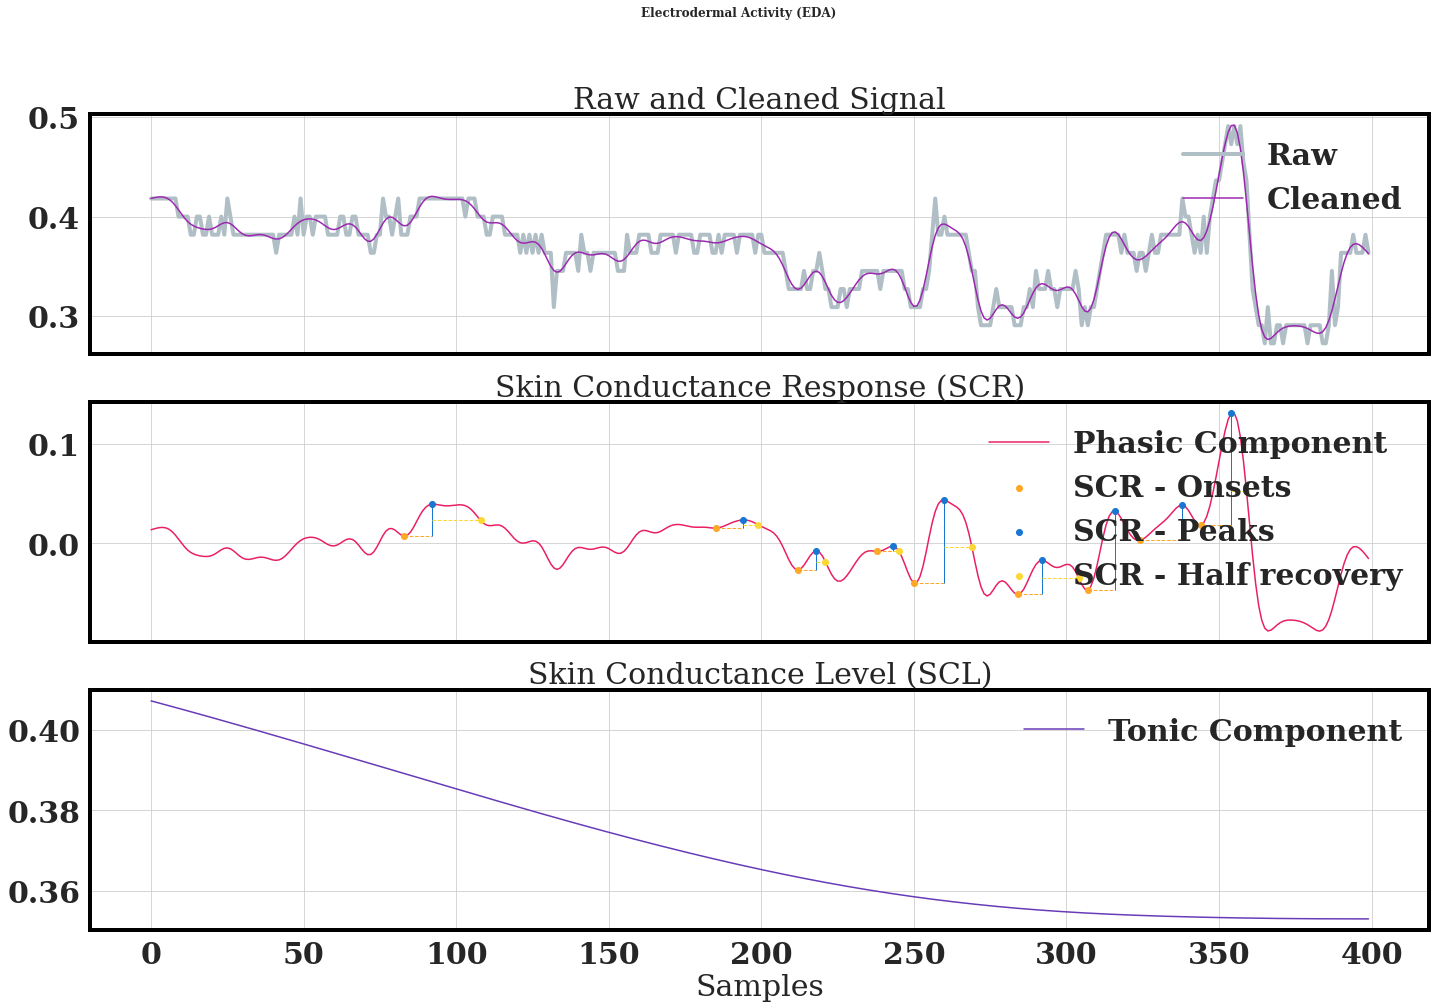

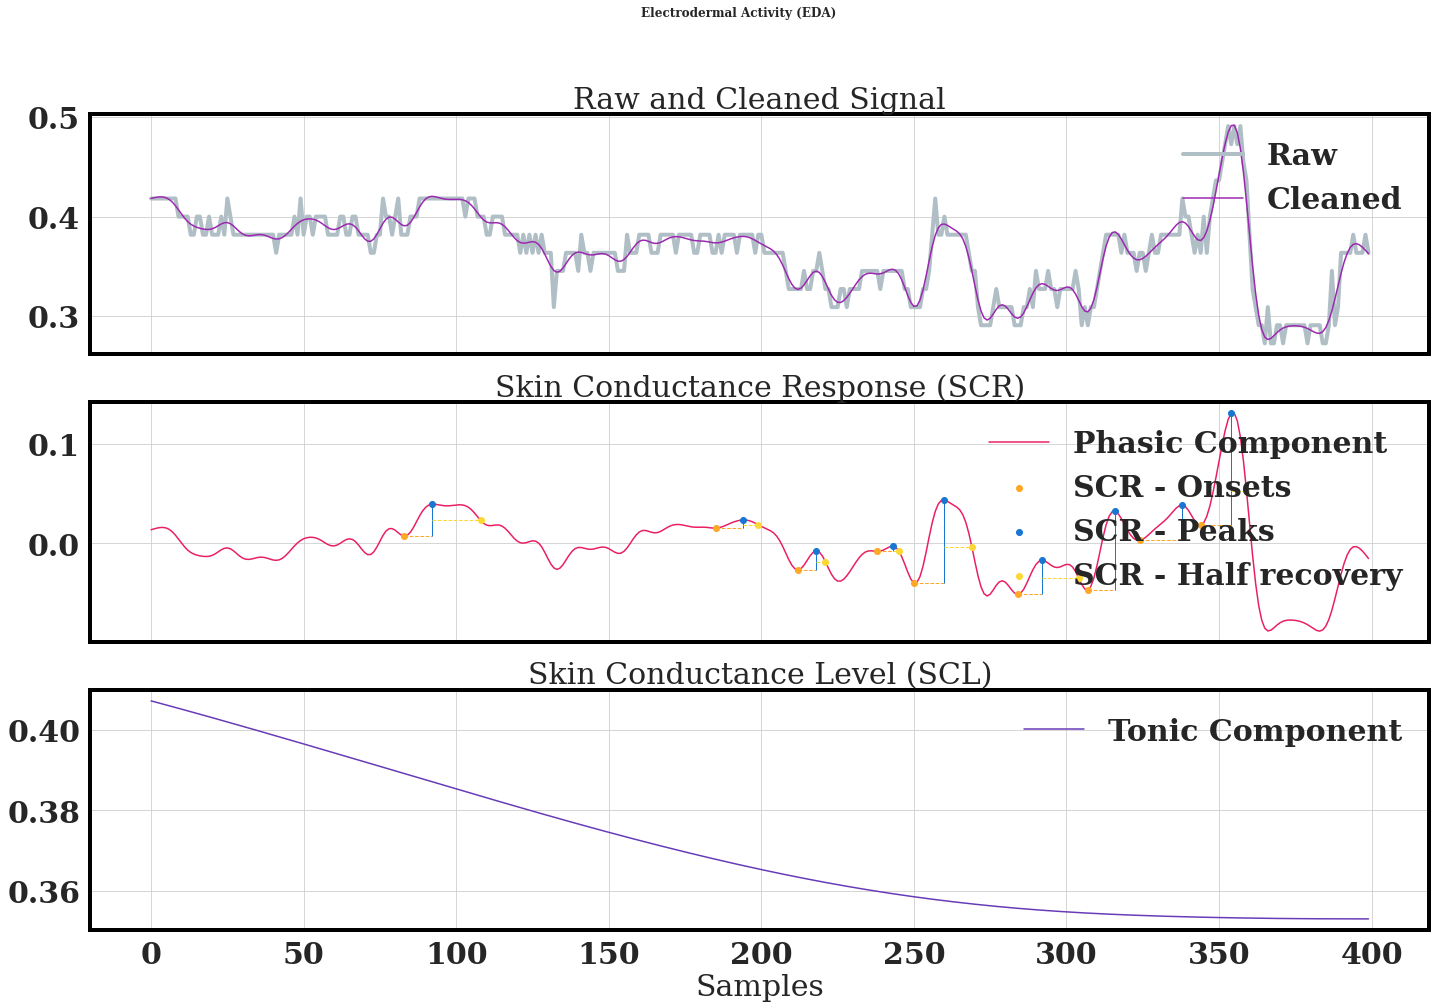

In [48]:
nk.eda_plot(signals)#[:500])

NameError: name 'raw_signal' is not defined

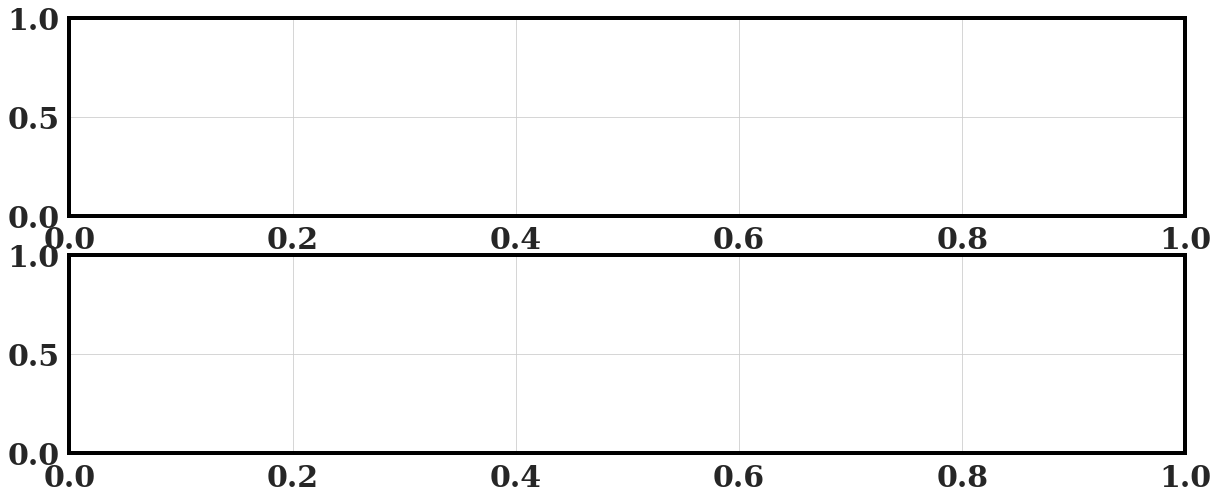

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))

ax[0].plot(raw_signal, label="Raw", color='gray', alpha=0.7)
ax[0].plot(cleaned_signal, label="Cleaned", color='purple')
ax[0].set_title("Raw and Cleaned Signal")
ax[0].set_xlabel("Samples")
ax[0].set_ylabel("Amplitude")
ax[0].legend(ncol=2)  # Adjust as needed

ax[1].plot(phasic_signal, label="Phasic Component", color='red')


for onset in onset_indices:
    ax[1].axvline(x=onset, color='blue', linestyle='--', label="SCR - Onsets", alpha=0.6)


for peak in peak_indices:
    ax[1].axvline(x=peak, color='orange', linestyle='--', label="SCR - Peaks", alpha=0.6)


for recovery in half_recovery_indices:
    ax[1].axvline(x=recovery, color='green', linestyle='--', label="SCR - Half-Recovery", alpha=0.6)


ax[1].set_title("Skin Conductance Response (SCR) with Onsets, Peaks, and Half-Recovery")
ax[1].set_xlabel("Samples")
ax[1].set_ylabel("Amplitude")


handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys(), ncol=3)

plt.tight_layout()
plt.show()

In [30]:
print(signals.columns)

Index(['EDA_Raw', 'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic', 'SCR_Onsets',
       'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime',
       'SCR_Recovery', 'SCR_RecoveryTime'],
      dtype='object')


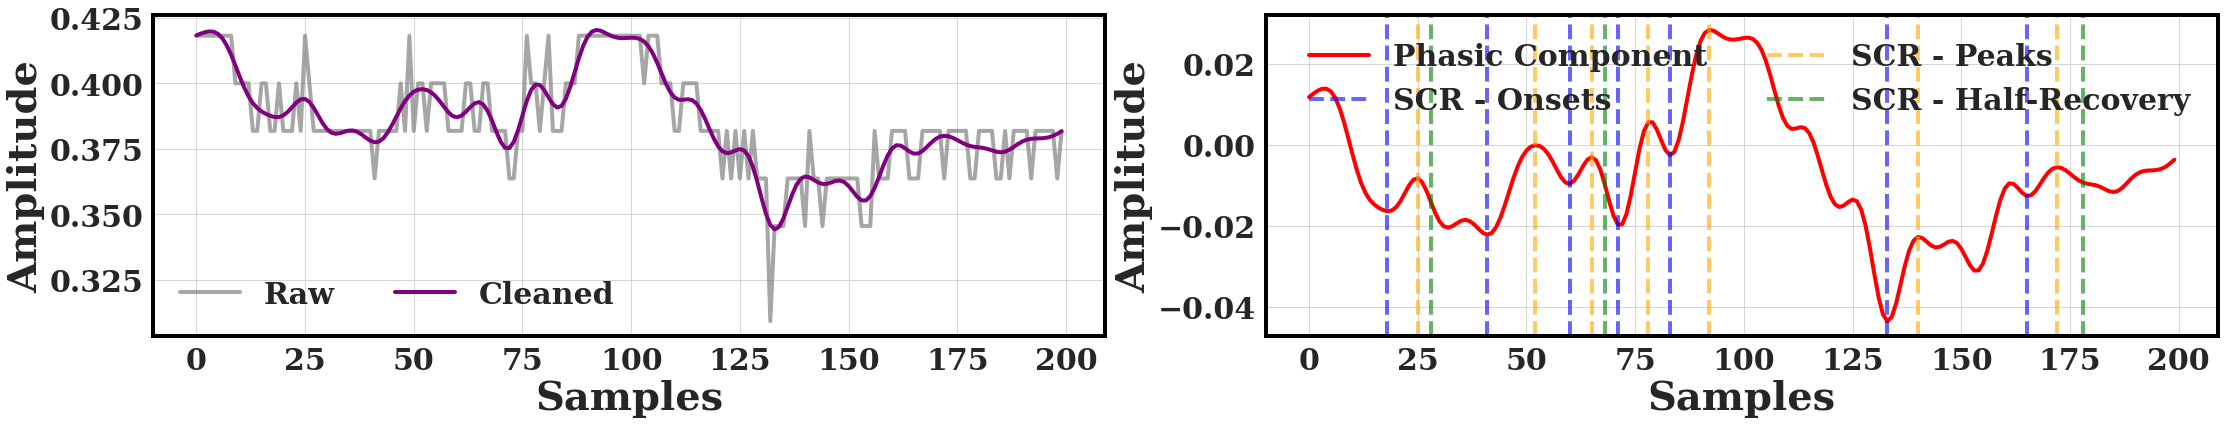

In [39]:
# Extract relevant signals
raw_signal = signals["EDA_Raw"]
cleaned_signal = signals["EDA_Clean"]
phasic_signal = signals["EDA_Phasic"]
scr_onsets = signals["SCR_Onsets"]
scr_peaks = signals["SCR_Peaks"]
scr_half_recovery = signals["SCR_RecoveryTime"]  # Assuming this is the correct column for half-recovery

# Debug: Check if there are any recovery points
#print("Half-Recovery Values:")
#print(scr_half_recovery.value_counts())

# Get the indices where SCR onsets, peaks, and half-recovery occur
onset_indices = scr_onsets[scr_onsets == 1].index
peak_indices = scr_peaks[scr_peaks == 1].index
half_recovery_indices = scr_half_recovery[scr_half_recovery > 0].index  # Use non-zero recovery points

# Debug: Check if half-recovery indices are detected
#print("Half-Recovery Indices:")
#print(half_recovery_indices)

# Plot SCR Components including Half-Recovery
fig, ax = plt.subplots(1, 2, figsize=(31, 6))

# Plot Raw and Cleaned Signal
ax[0].plot(raw_signal, label="Raw", color='gray', alpha=0.7)
ax[0].plot(cleaned_signal, label="Cleaned", color='purple')
#ax[0].set_title("Raw and Cleaned Signal")
ax[0].set_xlabel("Samples", fontweight='semibold', fontsize = '40')
ax[0].set_ylabel("Amplitude", fontweight='semibold', fontsize = '40')
ax[0].legend(ncol=2, prop=dict(weight='semibold'),fontsize = '30')

# Plot Phasic Component
ax[1].plot(phasic_signal, label="Phasic Component", color='red')

# Plot vertical lines for SCR Onsets
for onset in onset_indices:
    ax[1].axvline(x=onset, color='blue', linestyle='--', label="SCR - Onsets", alpha=0.6)

# Plot vertical lines for SCR Peaks
for peak in peak_indices:
    ax[1].axvline(x=peak, color='orange', linestyle='--', label="SCR - Peaks", alpha=0.6)

# Plot vertical lines for SCR Half-Recovery
for recovery in half_recovery_indices:
    ax[1].axvline(x=recovery, color='green', linestyle='--', label="SCR - Half-Recovery", alpha=0.6)

# Customize the plot
#ax[1].set_title("Skin Conductance Response (SCR) with Onsets, Peaks, and Half-Recovery")
ax[1].set_xlabel("Samples", fontweight='semibold', fontsize = '40')
ax[1].set_ylabel("Amplitude", fontweight='semibold', fontsize = '40')

# Ensure the legend has unique labels
handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys(), ncol=2, prop=dict(weight='semibold'),fontsize = '30')

plt.tight_layout()
plt.savefig('Figures/Preprocess_EDA1.png',dpi=300, bbox_inches='tight')
plt.show()

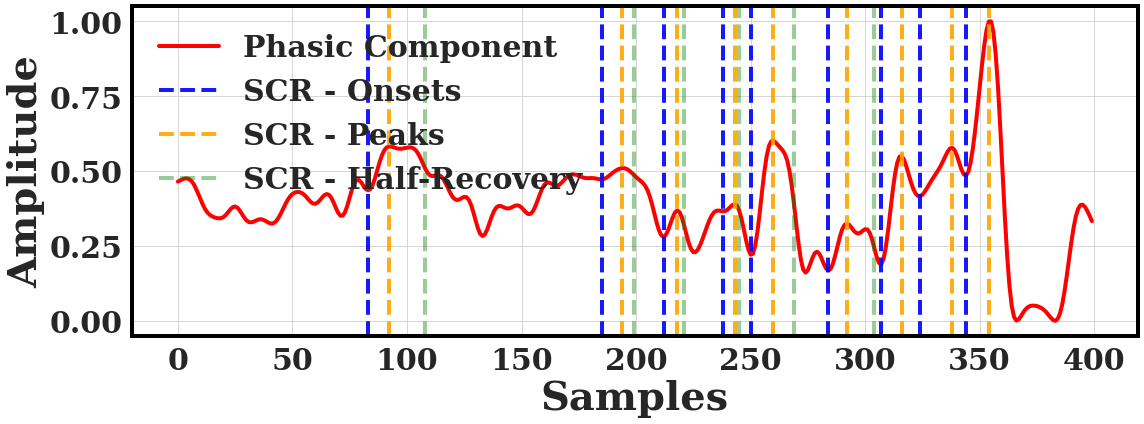

In [66]:
phasic_signal = signals["EDA_Phasic"].values.reshape(-1, 1)
scr_onsets = signals["SCR_Onsets"]
scr_peaks = signals["SCR_Peaks"]
scr_half_recovery = signals["SCR_RecoveryTime"]

# Normalize Phasic Component using Min-Max Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
phasic_signal_normalized = scaler.fit_transform(phasic_signal).flatten()

# Get the indices where SCR onsets, peaks, and half-recovery occur
onset_indices = scr_onsets[scr_onsets == 1].index
peak_indices = scr_peaks[scr_peaks == 1].index
half_recovery_indices = scr_half_recovery[scr_half_recovery > 0].index  # Non-zero recovery points

# Plot SCR Components including Onsets, Peaks, and Half-Recovery
fig, ax = plt.subplots(figsize=(16, 6))

# Plot Normalized Phasic Component
ax.plot(phasic_signal_normalized, label="Phasic Component", color='red')

# Plot vertical lines for SCR Onsets
for onset in onset_indices:
    ax.axvline(x=onset, color='blue', linestyle='--', label="SCR - Onsets", alpha=0.9)

# Plot vertical lines for SCR Peaks
for peak in peak_indices:
    ax.axvline(x=peak, color='orange', linestyle='--', label="SCR - Peaks", alpha=0.9)

# Plot vertical lines for SCR Half-Recovery
for recovery in half_recovery_indices:
    ax.axvline(x=recovery, color='green', linestyle='--', label="SCR - Half-Recovery", alpha=0.4)

# Customize the plot
ax.set_xlabel("Samples", fontweight='semibold', fontsize=40)
ax.set_ylabel("Amplitude", fontweight='semibold', fontsize=40)

# Ensure the legend has unique labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), ncol=1, prop=dict(weight='semibold'), fontsize=20, loc = 'upper left')

plt.tight_layout()
#plt.savefig('Figures/Preprocess_GSR.png', dpi=300, bbox_inches='tight')
plt.show()

In [116]:
bd = np.array(d['PPG_Cal']) 

In [117]:
def apply_chebyshev2_bandpass(signal, low_cutoff_freq, high_cutoff_freq, sampling_freq, rp, rs, order=4):
    nyquist_freq = 0.5 * sampling_freq
    low_normalized_cutoff = low_cutoff_freq / nyquist_freq
    high_normalized_cutoff = high_cutoff_freq / nyquist_freq
    b, a = cheby2(order, rs, [low_normalized_cutoff, high_normalized_cutoff], btype='band', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply Chebyshev Type II bandpass filter with cutoff frequencies of 3 Hz and 7 Hz
filtered_signal = apply_chebyshev2_bandpass(bd, low_cutoff_freq=0.1, high_cutoff_freq=5, sampling_freq=32, rp=0.5, rs=10)

print("Original Signal:", signal)
print("Filtered Signal:", filtered_signal)

Original Signal:         PPG_Raw  PPG_Clean    PPG_Rate  PPG_Peaks
1000  29.981586   0.086061   98.187212        0.0
1001  30.074370   0.105161  100.791651        0.0
1002  29.946100   0.036203  103.267285        0.0
1003  29.903894  -0.071619  105.567768        0.0
1004  29.804650  -0.136827  107.643776        0.0
...         ...        ...         ...        ...
1495  29.914942  -0.413590   47.833501        0.0
1496  30.159034  -0.116204   47.478498        0.0
1497  30.548671   0.221034   47.198621        0.0
1498  30.805085   0.503360   46.995513        0.0
1499  30.994236   0.656094   46.871416        0.0

[500 rows x 4 columns]
Filtered Signal: [29.75856936 29.45388567 29.27742993 ... 30.55675424 30.4899279
 30.39920555]


In [118]:
signal, info = nk.ppg_process(filtered_signal, sampling_rate=32)

In [119]:
signal = signal[1000:1500]

In [110]:
#nk.ppg_plot(signal.iloc[1000:1500])

#selected_signal = signal.iloc[1000:1500].reset_index(drop=True)

#nk.ppg_plot(signal)

In [1]:
raw_signal = signal["PPG_Raw"]
cleaned_signal = signal["PPG_Clean"]
ppg_peaks = signal["PPG_Peaks"]

time = np.arange(len(raw_signal))


plt.figure(figsize=(16, 6))


plt.plot(time, raw_signal, label="Raw PPG", color='gray', alpha=0.7)


plt.plot(time, cleaned_signal, label="Cleaned PPG", color='purple', alpha=0.8)
plt.scatter(time[ppg_peaks == 1], cleaned_signal[ppg_peaks == 1], color='red', label="PPG Peaks", zorder=5)


#plt.title("Raw and Cleaned PPG Signals with Detected Peaks", fontsize=16)
plt.xlabel("Samples",  fontweight='semibold', fontsize = '40')
plt.ylabel("Amplitude",  fontweight='semibold', fontsize = '40')
plt.legend(ncol=2, prop=dict(weight='semibold'),fontsize = '40')
plt.grid(True)

plt.tight_layout()
#plt.savefig('Figures/Preprocess_PPG.png',dpi=300, bbox_inches='tight')
#plt.show()


NameError: name 'signal' is not defined

Filtered Signal: [29.75856936 29.45388567 29.27742993 ... 30.55675424 30.4899279
 30.39920555]


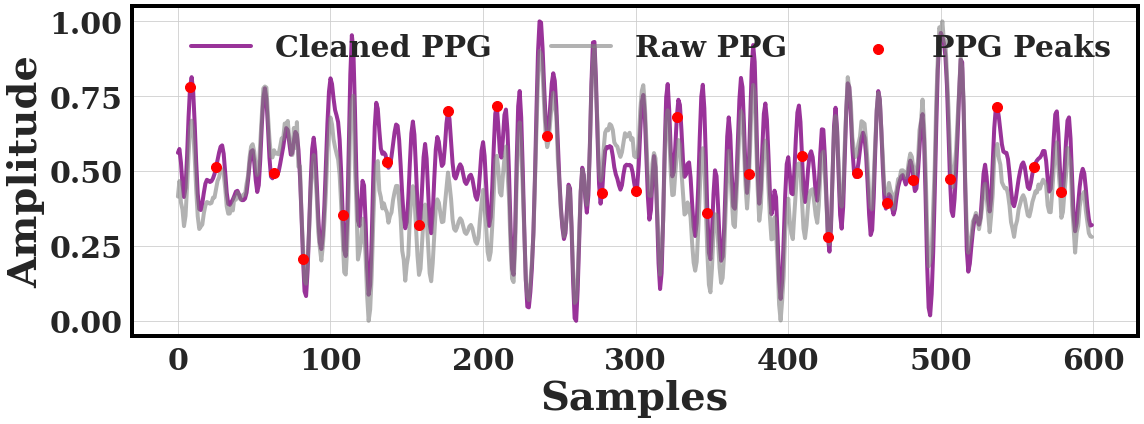

Mean HR: 90.20 BPM
SDNN: 0.13 sec
RMSSD: 0.18 sec
pNN50: 88.89%


In [140]:
# bd = np.array(d['PPG_Cal'])


def apply_chebyshev2_bandpass(signal_in, low_cutoff_freq, high_cutoff_freq, sampling_freq, rp, rs, order=4):
    nyquist_freq = 0.5 * sampling_freq
    low_normalized_cutoff = low_cutoff_freq / nyquist_freq
    high_normalized_cutoff = high_cutoff_freq / nyquist_freq
    b, a = sps.cheby2(order, rs, [low_normalized_cutoff, high_normalized_cutoff], btype='band', analog=False)
    filtered = sps.filtfilt(b, a, signal_in)
    return filtered


filtered_signal = apply_chebyshev2_bandpass(bd, low_cutoff_freq=0.1, high_cutoff_freq=5, sampling_freq=32, rp=0.5, rs=10)
print("Filtered Signal:", filtered_signal)


fs = 32  
ppg_data, info = nk.ppg_process(filtered_signal, sampling_rate=fs)


if len(ppg_data) >= 1600:
    ppg_data = ppg_data[1000:1600]
else:
    ppg_data = ppg_data


raw_signal = ppg_data["PPG_Raw"].values
cleaned_signal = ppg_data["PPG_Clean"].values
ppg_peaks = ppg_data["PPG_Peaks"]
time = np.arange(len(raw_signal))

scaler = MinMaxScaler(feature_range=(0, 1))
cleaned_signal_normalized = scaler.fit_transform(cleaned_signal.reshape(-1, 1)).flatten()
raw_signal_normalized = scaler.fit_transform(raw_signal.reshape(-1, 1)).flatten()


nyquist = fs / 2
cutoff = 5  
b, a = sps.butter(3, cutoff / nyquist, btype='low')
filtered_signal_norm = sps.filtfilt(b, a, cleaned_signal_normalized)


window_size = 16
smoothed_signal = np.convolve(filtered_signal_norm, np.ones(window_size) / window_size, mode='same')

peaks, _ = sps.find_peaks(smoothed_signal, height=0.75 * np.median(smoothed_signal), distance=int(0.5 * fs))


ibi = np.diff(peaks) / fs  
median_ibi = np.median(ibi)
ibi_filtered = ibi[(ibi >= 0.7 * median_ibi) & (ibi <= 1.3 * median_ibi)]  

heart_rate = 60 / ibi_filtered 
sdnn = np.std(ibi_filtered)      
rmssd = np.sqrt(np.mean(np.square(np.diff(ibi_filtered))))  
pnn50 = np.sum(np.abs(np.diff(ibi_filtered)) > 0.05) / len(ibi_filtered) * 100  


fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(time, cleaned_signal_normalized, label="Cleaned PPG", color='purple', alpha=0.8)
plt.plot(time, raw_signal_normalized, label="Raw PPG", color='gray', alpha=0.6)
ax.scatter(peaks, cleaned_signal_normalized[peaks], color='red', label="PPG Peaks", zorder=5, s=100)
ax.set_xlabel("Samples", fontweight='semibold', fontsize=40)
ax.set_ylabel("Amplitude", fontweight='semibold', fontsize=40)
ax.legend(ncol=3, prop=dict(weight='semibold'), fontsize=20)
ax.grid(True)
plt.tight_layout()
plt.savefig('Figures/Preprocess_PPG_HRV.png',dpi=300, bbox_inches='tight')
plt.show()

# --- Print HRV Metrics ---
print(f"Mean HR: {np.mean(heart_rate):.2f} BPM")
print(f"SDNN: {sdnn:.2f} sec")
print(f"RMSSD: {rmssd:.2f} sec")
print(f"pNN50: {pnn50:.2f}%")

In [2]:
bd = np.array(d['PPG_Cal'])


def apply_chebyshev2_bandpass(signal_in, low_cutoff_freq, high_cutoff_freq, sampling_freq, rp, rs, order=4):
    nyquist_freq = 0.5 * sampling_freq
    low_normalized_cutoff = low_cutoff_freq / nyquist_freq
    high_normalized_cutoff = high_cutoff_freq / nyquist_freq
    b, a = sps.cheby2(order, rs, [low_normalized_cutoff, high_normalized_cutoff], btype='band', analog=False)
    filtered = sps.filtfilt(b, a, signal_in)
    return filtered


filtered_signal = apply_chebyshev2_bandpass(bd, low_cutoff_freq=0.1, high_cutoff_freq=5, sampling_freq=32, rp=0.5, rs=10)
print("Filtered Signal:", filtered_signal)


fs = 32  
ppg_data, info = nk.ppg_process(filtered_signal, sampling_rate=fs)


if len(ppg_data) >= 1600:
    ppg_data = ppg_data[1000:1600]  
else:
    ppg_data = ppg_data  


raw_signal = ppg_data["PPG_Raw"].values
cleaned_signal = ppg_data["PPG_Clean"].values
ppg_peaks = ppg_data["PPG_Peaks"]
time = np.arange(len(raw_signal))


scaler = MinMaxScaler(feature_range=(0, 1))
cleaned_signal_normalized = scaler.fit_transform(cleaned_signal.reshape(-1, 1)).flatten()


nyquist = fs / 2
cutoff = 5  
b, a = sps.butter(3, cutoff / nyquist, btype='low')
filtered_signal_norm = sps.filtfilt(b, a, cleaned_signal_normalized)

# **Step 4: Apply Moving Average Filter (16 samples = 0.25s)**
window_size = 16
smoothed_signal = np.convolve(filtered_signal_norm, np.ones(window_size) / window_size, mode='same')


peaks, _ = sps.find_peaks(smoothed_signal, height=0.75 * np.median(smoothed_signal), distance=int(0.5 * fs))


ibi = np.diff(peaks) / fs  
median_ibi = np.median(ibi)
ibi_filtered = ibi[(ibi >= 0.7 * median_ibi) & (ibi <= 1.3 * median_ibi)]


heart_rate = 60 / ibi_filtered  # BPM
sdnn = np.std(ibi_filtered)      # Standard deviation of NN intervals
rmssd = np.sqrt(np.mean(np.square(np.diff(ibi_filtered))))  # RMSSD metric
pnn50 = np.sum(np.abs(np.diff(ibi_filtered)) > 0.05) / len(ibi_filtered) * 100  # pNN50 in %


fig, ax = plt.subplots(1, 2, figsize=(16, 6))


ax[0].plot(time, cleaned_signal_normalized, label="Cleaned PPG", color='purple', alpha=0.8)
ax[0].scatter(peaks, cleaned_signal_normalized[peaks], color='red', label="PPG Peaks", zorder=5)
ax[0].set_xlabel("Samples", fontweight='semibold', fontsize=20)
ax[0].set_ylabel("Normalized Amplitude", fontweight='semibold', fontsize=20)
ax[0].legend(ncol=2, prop=dict(weight='semibold'), fontsize=14)
ax[0].grid(True)


ax[1].hist(ibi_filtered, bins=20, color='blue', alpha=0.7,
           label=f"Mean HR: {np.mean(heart_rate):.2f} BPM\nSDNN: {sdnn:.2f} sec\nRMSSD: {rmssd:.2f} sec\npNN50: {pnn50:.2f}%")
ax[1].set_xlabel("IBI (s)", fontweight='semibold', fontsize=20)
ax[1].set_ylabel("Frequency", fontweight='semibold', fontsize=20)
ax[1].legend(fontsize=14)
ax[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Mean HR: {np.mean(heart_rate):.2f} BPM")
print(f"SDNN: {sdnn:.2f} sec")
print(f"RMSSD: {rmssd:.2f} sec")
print(f"pNN50: {pnn50:.2f}%")

NameError: name 'np' is not defined